##이미지 어디까지 우려볼까? 

개발 환경
<br/>데이터 정보

데이터 증강
<br/>Preprocessing
<br/>Basic Augmentation
<br/>Cutmix
<br/>Mixup
<br/>Normalize
<br/>Dataset

모델 구성
<br/>모델 학습
<br/>모델 평가
<br/>결론
<br/>참고문헌

# 개발 환경 

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#데이터 정보

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,)

[stanford-dogs-dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)

stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있다.
<br/>총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋이다.

In [ ]:
ds_info_splits = "Train Data Size: " + str(ds_info.splits['train'].num_examples) + \
              "\nTest Data Size: " + str(ds_info.splits['test'].num_examples)

reorderlist = ['name', 'full_name', 'description', 'supervised_keys', 'disable_shuffling', 'homepage',
               'data_path', 'file_format', 'download_size', 'dataset_size', 'features', 'supervised_keys',
               'disable_shuffling', 'splits', 'citation']

ds_info_dict = pd.DataFrame({'tfds.core.DatasetInfo':{'name':ds_info.name, 'full_name':ds_info.full_name,
                                     'description':ds_info.description.replace('resources', 'resources<br/>'),
                                     'supervised_keys':ds_info.supervised_keys, 
                                     'disable_shuffling':ds_info.disable_shuffling, 'homepage':ds_info.homepage, 
                                     'data_path': '~/tensorflow_datasets/stanford_dogs/0.2.0',
                                     'file_format':ds_info.file_format, 'download_size':ds_info.download_size,
                                     'dataset_size':ds_info.dataset_size, 'features':ds_info.features,
                                      'supervised_keys':ds_info.supervised_keys, 'disable_shuffling': ds_info.disable_shuffling,
                                      'splits': ds_info_splits.replace('\n', '<br/>'),  'citation':ds_info.citation.replace('\n', '<br/>')}})
ds_info_df = pd.DataFrame(ds_info_dict)
ds_info_df = ds_info_df.reindex(reorderlist).reset_index()
from pandas import option_context
with option_context('display.max_colwidth', None):
  display(ds_info_df.style.set_properties(**{'text-align': 'center'}))

,index,tfds.core.DatasetInfo
0,name,stanford_dogs
1,full_name,stanford_dogs/0.2.0
2,description,"The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. There are 20,580 images, out of which 12,000 are used for training and 8580 for testing. Class labels and bounding box annotations are provided for all the 12,000 images."
3,supervised_keys,"('image', 'label')"
4,disable_shuffling,False
5,homepage,http://vision.stanford.edu/aditya86/ImageNetDogs/main.html
6,data_path,~/tensorflow_datasets/stanford_dogs/0.2.0
7,file_format,FileFormat.TFRECORD
8,download_size,778.12 MiB
9,dataset_size,744.72 MiB


<br/><br/>

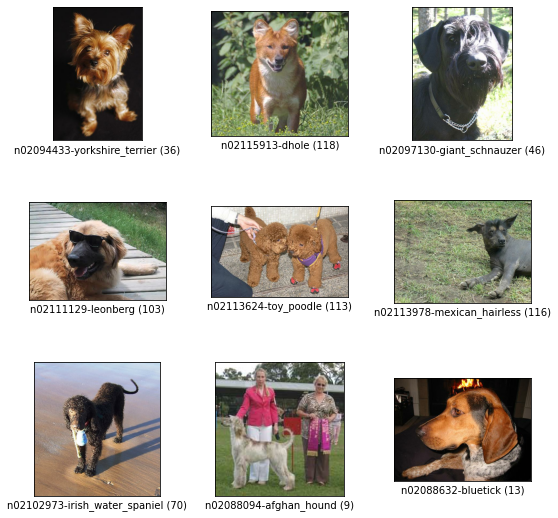

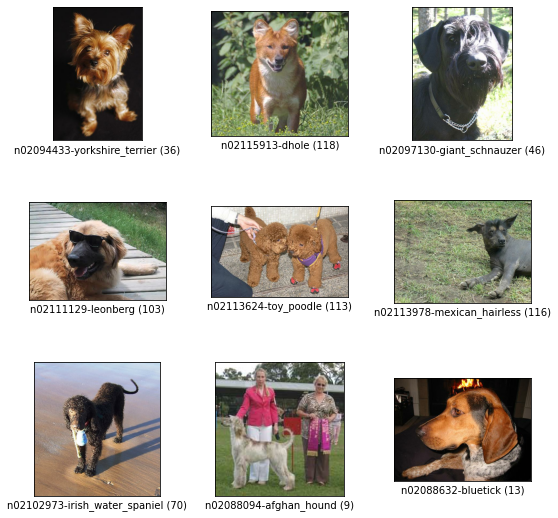

In [ ]:
tfds.show_examples(ds_train, ds_info)

<br/><br/>

#데이터 증강

##Preprocessing

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

입력받은 이미지를 0~1 사이의 float32로 normalize하고 (224, 224) 사이즈로 resize한다.

##Basic Augmentation 

In [ ]:
# Basic augmentation : flip left and right, Aujust brightness
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

random augmentation 중에서 random_flip_left_right() 과 random_brightness() 를 활용한다.
<br/>"flip"의 경우 좌우 대칭을 한다.

In [ ]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

##Cutmix

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = 224
    image_size_y = 224
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [ ]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [ ]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = 224
    image_size_y = 224
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

##Mixup

In [ ]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [ ]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

##Normalize

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, 
                               with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug: # basic augmentation
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    if not is_test and with_aug and with_cutmix: # cutmix
        ds = ds.map(augment)
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and with_aug and with_mixup: # mixup
        ds = ds.map(augment)
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

apply_normalize_on_dataset() 를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용한다.
<br/>이때 주의해야 할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다.

##Dataset

In [ ]:
num_classes = ds_info.features["label"].num_classes

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

#모델 구성

코드는 텐서플로우 케라스의 ResNet50 중 imagenet 으로 훈련된 모델을 불러온다.
<br/>include_top 은 마지막 fully connected layer를 포함할지 여부이다.
<br/>해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 
<br/>필요에 맞게 수정된 fully connected layer를 붙여서 활용한다.

이렇게 하는 이유는 이미지넷 (ImageNet)과 테스트셋이 서로 다른 클래스를 가지므로 <br/>마지막에 추가해야 하는 fully connected layer의 구조 (뉴런의 개수) 또한 다르기 때문이다.

In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#모델 학습

In [ ]:
EPOCH = 20  

In [ ]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

with tf.device('/device:GPU:0'):
  history_resnet50_no_aug = resnet50.fit(
      ds_train_no_aug, 
      steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
      validation_steps=int(ds_info.splits['test'].num_examples/16),
      epochs=EPOCH,
      validation_data=ds_test,
      verbose=1,
      use_multiprocessing=True,
      )

Epoch 1/20
750/750 [==============================] - 165s 210ms/step - loss: 2.1803 - accuracy: 0.4542 - val_loss: 3.3929 - val_accuracy: 0.2028
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 0.6680 - accuracy: 0.8201 - val_loss: 1.0867 - val_accuracy: 0.6819
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 0.1791 - accuracy: 0.9687 - val_loss: 0.9122 - val_accuracy: 0.7308
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0518 - accuracy: 0.9964 - val_loss: 0.8922 - val_accuracy: 0.7459
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0485 - accuracy: 0.9965 - val_loss: 0.9271 - val_accuracy: 0.7350
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0171 - accuracy: 0.9995 - val_loss: 0.9079 - val_accuracy: 0.7480
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0092 - accuracy: 0.9999 - val_loss: 0.9071 -

<br/><br/>

In [ ]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

with tf.device('/device:GPU:0'):
  history_resnet50_aug = aug_resnet50.fit(
      ds_train_aug,
      steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
      validation_steps=int(ds_info.splits['test'].num_examples/16),
      epochs=EPOCH,
      validation_data=ds_test,
      verbose=1,
      use_multiprocessing=True,
      )

Epoch 1/20
750/750 [==============================] - 167s 211ms/step - loss: 2.2974 - accuracy: 0.4302 - val_loss: 2.9396 - val_accuracy: 0.2786
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 0.9418 - accuracy: 0.7287 - val_loss: 1.2730 - val_accuracy: 0.6329
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 0.5366 - accuracy: 0.8498 - val_loss: 1.0479 - val_accuracy: 0.6965
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 0.2707 - accuracy: 0.9325 - val_loss: 1.1421 - val_accuracy: 0.6740
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 0.1370 - accuracy: 0.9748 - val_loss: 1.0104 - val_accuracy: 0.7181
Epoch 6/20
750/750 [==============================] - 158s 210ms/step - loss: 0.0763 - accuracy: 0.9891 - val_loss: 0.9621 - val_accuracy: 0.7317
Epoch 7/20
750/750 [==============================] - 158s 210ms/step - loss: 0.0450 - accuracy: 0.9955 - val_loss: 0.9630 -

<br/><br/>

In [ ]:
cutmix_resnet50.compile(
    loss= 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

with tf.device('/device:GPU:0'):
  history_cutmix_aug = cutmix_resnet50.fit(
      ds_train_cutmix,
      steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
      validation_steps=int(ds_info.splits['test'].num_examples/16),
      epochs=EPOCH,
      validation_data=ds_test,
      verbose=1,
      use_multiprocessing=True,
      )

Epoch 1/20
750/750 [==============================] - 183s 213ms/step - loss: 3.9066 - accuracy: 0.1918 - val_loss: 3.1771 - val_accuracy: 0.2446
Epoch 2/20
750/750 [==============================] - 159s 212ms/step - loss: 3.0809 - accuracy: 0.3875 - val_loss: 1.5324 - val_accuracy: 0.5739
Epoch 3/20
750/750 [==============================] - 159s 212ms/step - loss: 2.7996 - accuracy: 0.4793 - val_loss: 1.4078 - val_accuracy: 0.6136
Epoch 4/20
750/750 [==============================] - 159s 211ms/step - loss: 2.6136 - accuracy: 0.5363 - val_loss: 1.3396 - val_accuracy: 0.6307
Epoch 5/20
750/750 [==============================] - 173s 230ms/step - loss: 2.4884 - accuracy: 0.5813 - val_loss: 1.1455 - val_accuracy: 0.6823
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 2.3726 - accuracy: 0.6137 - val_loss: 1.2832 - val_accuracy: 0.6495
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 2.2878 - accuracy: 0.6342 - val_loss: 1.1170 -

<br/><br/>

In [ ]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

with tf.device('/device:GPU:0'):
  history_mixup_aug = mixup_resnet50.fit(
      ds_train_mixup, 
      steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
      validation_steps=int(ds_info.splits['test'].num_examples/16),
      epochs=EPOCH,
      validation_data=ds_test,
      verbose=1,
      use_multiprocessing=True,
      )

Epoch 1/20
750/750 [==============================] - 168s 212ms/step - loss: 3.8172 - accuracy: 0.2134 - val_loss: 3.7953 - val_accuracy: 0.1340
Epoch 2/20
750/750 [==============================] - 158s 210ms/step - loss: 2.9844 - accuracy: 0.4252 - val_loss: 1.6196 - val_accuracy: 0.5400
Epoch 3/20
750/750 [==============================] - 158s 211ms/step - loss: 2.7341 - accuracy: 0.5203 - val_loss: 1.3963 - val_accuracy: 0.6021
Epoch 4/20
750/750 [==============================] - 158s 211ms/step - loss: 2.5664 - accuracy: 0.5841 - val_loss: 1.3149 - val_accuracy: 0.6241
Epoch 5/20
750/750 [==============================] - 158s 211ms/step - loss: 2.4448 - accuracy: 0.6349 - val_loss: 1.5200 - val_accuracy: 0.5892
Epoch 6/20
750/750 [==============================] - 160s 213ms/step - loss: 2.3285 - accuracy: 0.6753 - val_loss: 1.3086 - val_accuracy: 0.6418
Epoch 7/20
750/750 [==============================] - 159s 213ms/step - loss: 2.2334 - accuracy: 0.7042 - val_loss: 1.2625 -

<br/><br/>

#모델 평가

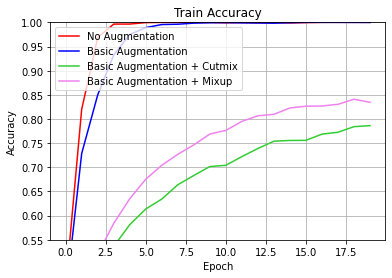

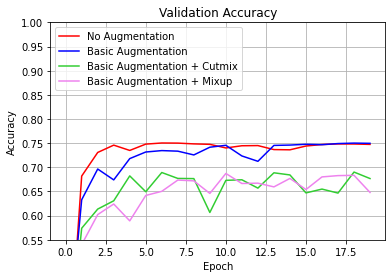

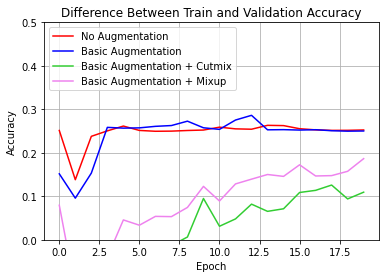

In [63]:
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_cutmix_aug.history['accuracy'], color='limegreen')
plt.plot(history_mixup_aug.history['accuracy'], color='violet')
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation','Basic Augmentation + Cutmix','Basic Augmentation + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.55, 1.00) 
plt.show()

print("\n" * 4)

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_cutmix_aug.history['val_accuracy'], color='limegreen')
plt.plot(history_mixup_aug.history['val_accuracy'], color='violet')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation','Basic Augmentation + Cutmix','Basic Augmentation + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.55, 1.00) 
plt.show()

print("\n" * 4)

plt.plot(list(map(operator.sub, history_resnet50_no_aug.history['accuracy'],  history_resnet50_no_aug.history['val_accuracy'])), 'r')
plt.plot(list(map(operator.sub, history_resnet50_aug.history['accuracy'],  history_resnet50_aug.history['val_accuracy'])), 'b')
plt.plot(list(map(operator.sub, history_cutmix_aug.history['accuracy'],  history_cutmix_aug.history['val_accuracy'])), color='limegreen')
plt.plot(list(map(operator.sub, history_mixup_aug.history['accuracy'],  history_mixup_aug.history['val_accuracy'])), color='violet')
plt.title('Difference Between Train and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation','Basic Augmentation + Cutmix','Basic Augmentation + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.00, 0.50) 
plt.show()

<br/><br/>

#결론

모델의 Train Accuracy는 No Augmentation, Basic Augmentation(Flip Left Right, Audjust Brightness), Basic Augmentation + Cutmix, Basic Augmentation + Mixup을 적용한 순으로 높다.

모델의 Train Accuracy과 Validation Accuracy의 차이를 보면
<br/>No Augmentation, Basic Augmentation(Flip Left Right, Audjust Brightness)의 과적합 발생 가능성이 크고
<br/>비교적 Basic Augmentation + Cutmix,Basic Augmentation + Mixup 과적합 발생 가능성이 작다.

<br/>

#참고문헌

**LMS**
<br/>[wer2774](https://github.com/Sangkwun)

<br/>**공식 사이트**
<br/>Stanford University
<br/>[stanford-dogs-dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)
<br/><br/>Google Colab
<br/>[TensorFlow with GPU](https://colab.research.google.com/notebooks/gpu.ipynb?hl=ko#scrollTo=tMce8muBqXQP)

<br/>**Github**
<br/>seonghyun97
<br/>[GD-02 CutMix.ipynb](https://github.com/seonghyun97/Aiffel_GoingDeeper/blob/master/%5BGD-02%5DCutMix.ipynb)